In [1]:
from astropy.io import fits
from astropy.stats import biweight_midvariance as bwmv
from astropy.stats import median_absolute_deviation as mad
import astroalign as aa
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
# Shift the image
from scipy.ndimage import shift
import pandas as pd
import os

def fitsread(f, header=False):
    with fits.open(f) as hdul:
        data = hdul[0].data
        if header:
            h = hdul[0].header
            return data, h
        else:
            return data
        
def rescale(image, mref, sref, roi=None):
    imageV = image if roi is None else image[roi]
    m1 = np.median(imageV)
    s1 = mad(imageV)
    ki = sref/s1
    rimage = ki*(image - m1) + mref
    return rimage

In [2]:
# Masters
cal_dir = Path(os.environ['DATA'], 'DDS', 'Taka', 'Calibration')
dark300f = Path(cal_dir, 'masterDark300_bin2_average_Jan_2019.fits')

RFlatf = Path(cal_dir, 'masterRFlat_bin2_Jan_26_2019.fits')
GFlatf = Path(cal_dir, 'masterGFlat_bin2_Feb_3_2019.fits')
BFlatf = Path(cal_dir, 'masterBFlat_bin2_Feb_4_2019.fits')
# load master files
mDark = fitsread(dark300f)
rgbFlats = [fitsread(f) for f in[RFlatf, GFlatf, BFlatf]]

In [3]:
# lights
lights_dir = Path(os.environ['DATA'], 'DDS', 'Taka', 'Lights', 'IC_1805')
rgb = 'RGB'
rgbdirs = [Path(lights_dir, ch) for ch in rgb]
print('Directories exist for RGB?')
for cdir in rgbdirs: print(cdir.exists())
rgbf = [sorted(rgbdir.rglob('*.fit')) for rgbdir in rgbdirs]
print('Nb of files in each RGB channel: ', len(rgbf[0]), len(rgbf[1]), len(rgbf[2]))
# Field of view for a sample to compute statistical moments faster.
tfov0 = np.s_[:, -512:, -512]
fov0 = tfov0[1:]

Directories exist for RGB?
True
True
True
Nb of files in each RGB channel:  18 8 15


# GREEN

In [4]:
# Channel ch = 0, 1, 2 for R, G, B respectively
ch = 1
# Load 1st image to get reference statistics
im0 = fitsread(rgbf[ch][0])
# image size
sz = im0.shape
# Reference statistical moments
m0 = np.median(im0[fov0])
s0 = mad(im0[fov0])

### Make visual selection

In [5]:
fov = np.s_[750:750+256, 1000:1000+256]
vmin = np.percentile(im0, 0.01)
vmax = np.percentile(im0, 99.5)
print('vmin =', vmin, 'vmax =', vmax)
for f in rgbf[ch][0:]:
    light = fitsread(f)
    m1 = np.median(light[fov0])
    s1 = mad(light[fov0])
    ki = s0/s1
    light2 = rescale(light, m0, s0, fov0)
    plt.figure(figsize=(5,5))
    plt.imshow(light2[fov], vmin=vmin, vmax=vmax, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(Path(rgbdirs[ch], 'jpegs', f'{f.stem}.jpg'), bbox_inches = 'tight', pad_inches = 0)
    plt.close()

vmin = 1108.0 vmax = 4882.285000000149


In [5]:
# Load lights from curated list (if no rejection, just read the initial list)
clights = np.array([fitsread(f) for f in rgbf[ch]])

In [6]:
cCal1 = clights - mDark
cCal1V = cCal1[tfov0]

In [7]:
cCal2 = (cCal1 / rgbFlats[ch]).astype(np.float32)
cCal2V = cCal2[tfov0]

In [8]:
cregdir = Path(rgbdirs[ch], 'registered')
cregdir.mkdir(parents=False, exist_ok=True)
Path(cregdir, 'jpegs').mkdir(parents=False, exist_ok=True)

In [9]:
fov = np.s_[750:750+128, 1000:1000+128]
fov2 = np.s_[0:128, 0:128]
fov3 = np.s_[-128:, -128:]

# Rescale the reference image
mref = np.median(cCal1V[0])
sref = mad(cCal1V[0])
ref = rescale(cCal2[0], mref, sref, fov0)

vmin = 0
vmax = np.percentile(cCal1V[0], 99.9)

for i, f in enumerate(rgbf[ch][0:]):
    
    image2 = cCal2[i]

    image2 = rescale(image2, mref, sref, fov0)
    
    p, (pos_img, pos_img_rot) = aa.find_transform(image2, ref)
    image2 = cv2.warpPerspective(image2, p.params, (sz[1],sz[0]), flags=cv2.INTER_CUBIC);
    fits.writeto(Path(cregdir, f'reg.{f.stem}.fits'), image2.astype(np.float32), overwrite=True)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    axs[0].imshow(image2[fov], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[1].imshow(image2[fov2], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[2].imshow(image2[fov3], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    axs[1].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    axs[2].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    plt.tight_layout()
    plt.savefig(Path(cregdir, 'jpegs', f'{f.stem}.reg.aa.jpg'))
    plt.close()

In [10]:
cregf = sorted(cregdir.rglob('reg*.fits'))
len(cregf)

8

In [11]:
creg = np.array([fitsread(f) for f in cregf])

In [12]:
cstackmed = np.median(creg, axis=0)

In [13]:
fits.writeto(Path(lights_dir, 'stacked', f'{rgb[ch]}stackmed.fits'), cstackmed.astype(np.float32), overwrite=True)

vmin =  554.7937833923339 vmax =  3450.4514580078057


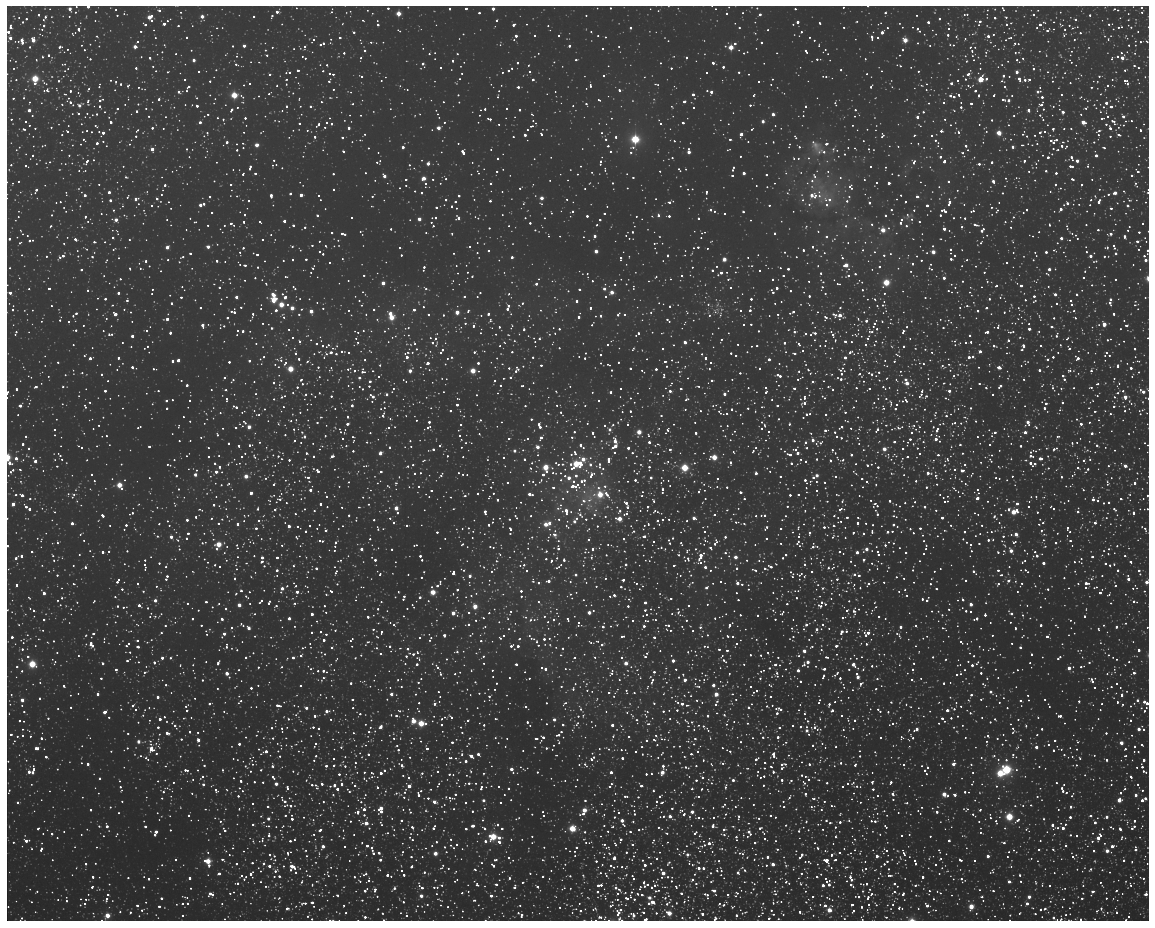

In [18]:
vmin = np.percentile(cstackmed, 0.03)
vmax = np.percentile(cstackmed, 98.8)
print('vmin = ', vmin, 'vmax = ', vmax)
plt.figure(figsize=(20,13))
plt.imshow(cstackmed, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked', f'{rgb[ch]}stackmed.jpg'), bbox_inches = 'tight', pad_inches = 0)

vmin =  1057.100341796875 vmax =  4967.616390624995


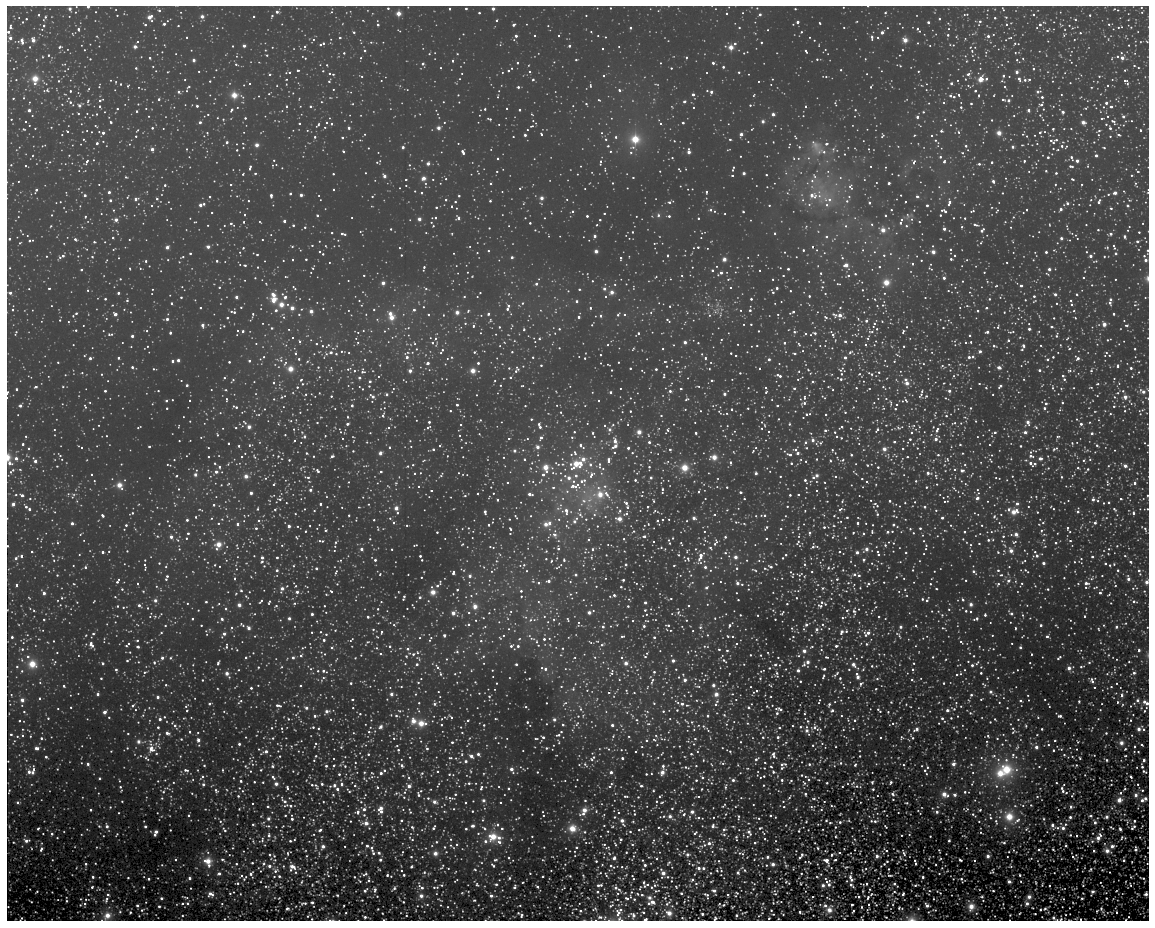

In [28]:
import matplotlib.colors as colors
vmin = np.percentile(cstackmed, 5)
vmax = np.percentile(cstackmed, 99.2)
print('vmin = ', vmin, 'vmax = ', vmax)
plt.figure(figsize=(20,13))
plt.imshow(cstackmed, origin='lower', cmap='gray', norm=colors.PowerNorm(gamma=0.4, vmin=vmin, vmax=vmax))
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked', f'{rgb[ch]}stackmed2.jpg'), bbox_inches = 'tight', pad_inches = 0)